# ✈️ FlightOnTime — Predição de Atrasos em Voos

O **FlightOnTime** é um projeto de *Data Science* e *Back-End* voltado para prever a probabilidade de um voo **decolar no horário ou com atraso**, utilizando dados históricos de aviação civil.  
Ele faz parte de um desafio educacional cujo objetivo é construir um **MVP preditivo** capaz de apoiar passageiros, companhias aéreas e aeroportos na tomada de decisão.

## Descrição do projeto

### 🎯 Objetivo do Projeto

Criar um modelo de classificação binária que, a partir de informações de um voo — como companhia aérea, origem, destino, horário e distância — estima se ele será **Pontual (0)** ou **Atrasado (1)**, retornando também a probabilidade associada.

---

### 🧠 Pipeline de Data Science

O notebook conduz as principais etapas do fluxo de ciência de dados:

1. **ETL e limpeza dos dados**  
   - Carregamento, padronização e enriquecimento das informações de voos.

2. **Engenharia de variáveis (Feature Engineering)**  
   - Extração de atributos relevantes, como:  
     hora do voo, dia da semana, distância, aeroportos, companhia aérea.

3. **Modelagem preditiva**  
   - Testes com algoritmos supervisionados (ex.: Logistic Regression, Random Forest).

4. **Avaliação do modelo**  
   - Métricas como Acurácia, Precisão, Recall e F1-score.

5. **Exportação do modelo treinado**  
   - Serialização via `joblib` para uso pela API de Back-End.

---

### 🛠️ Integração com a API

O modelo gerado neste notebook será consumido por uma **API REST em Java (Spring Boot)**, que disponibilizará o endpoint:

```
POST /predict
```

Retornando:

```json
{
  "previsao": "Atrasado",
  "probabilidade": 0.78
}
```

---

### 📌 Sobre o Dataset

O projeto utiliza um conjunto de dados contendo informações reais de voos, incluindo:

- companhia aérea  
- aeroporto de origem e destino  
- data e horário de partida  
- distância do trecho  
- status de atraso  

As funções de ETL foram previamente desenvolvidas para garantir limpeza, consistência e rastreabilidade.

## 🚀 Início do Notebook

A partir daqui, o notebook executa o fluxo completo de preparação, análise e modelagem, resultando em um modelo leve, funcional e pronto para produção no MVP do FlightOnTime.

### Imports Globais

In [2]:
import pandas as pd

from etl.etl import processar_dados, carregar_dados
from sklearn.model_selection import train_test_split

from utils.test_model import test_model
from utils.visualize_y import visualize_y
from utils.export_model import export_model
from utils.document_model import document_model
from utils.evaluate_model import evaluate_model
from utils.get_model_metadata import get_model_metadata
from utils.plot_automl_results import plot_algorithm_selection, plot_adaptive_sampling, plot_feature_selection, plot_model_tuning
from utils.experiment_automl_pipelines import run_experiments, evaluate_experimental_models, load_experimental_models

import automlx
from automlx import init # type: ignore

### Preprocessamento e Carga

Execute as funções abaixo para carregar os dados de fonte local ou para baixar, preprocessar e salvar os dados a partir da base de dados de vôos da ANAC (Agência Nacional de Aviação Civil).  

- Os dados são salvos em ./dados/
- A função `processar_dados` acessa toda a base de dados da ANAC a partir de Janeiro/2018 até Outubro/2025.
- O processo de ETL completo é executado durante o processo.
- A engenharia de features já foi executada durante o processo, gerando a coluna "Atrasado" (Y) 

Para mais informações sobre o processo, consulte a [Documentação](./etl/README.md) do módulo etl.

#### Preprocessar com origem externa

Baixa e executa o preprocessamento em tempo de execução através da base de dados abertos da ANAC.  
Link: https://sistemas.anac.gov.br/dadosabertos/Voos%20e%20opera%C3%A7%C3%B5es%20a%C3%A9reas/Voo%20Regular%20Ativo%20%28VRA%29/

In [ ]:
# Código comentado por segurança
# Descomente a linha abaixo para executar o pipeline ETL completo

# df = processar_dados()

Iniciando o download e preprocessamento de 94 arquivos CSV...

[1/94] Carregando: http://.../2018/01%20-%20Janeiro/VRA_20181.csv
✔ 25790 linhas carregadas.
   Total atual de linhas: 25790
   Memória usada: 0.41 MB

[2/94] Carregando: http://.../2018/02%20-%20Fevereiro/VRA_20182.csv
✔ 29722 linhas carregadas.
   Total atual de linhas: 55512
   Memória usada: 0.89 MB

[3/94] Carregando: http://.../2018/03%20-%20Mar%C3%A7o/VRA_20183.csv
✔ 42401 linhas carregadas.
   Total atual de linhas: 97913
   Memória usada: 1.56 MB

[4/94] Carregando: http://.../2018/04%20-%20Abril/VRA_20184.csv
✔ 63150 linhas carregadas.
   Total atual de linhas: 161063
   Memória usada: 2.67 MB


🏁 Finalizado.

Total de linhas carregadas: 161063
Memória usada no Dataframe Master: 29.95 MB

📁 Arquivo salvo com sucesso:
   → ./data/dados_voos_20260115_184202.parquet


#### Preprocessar com origem local

Exemplo de nome de arquivo local:  
```python
filename = "dados_voos_20250101_153000"
```

- Não necessita informar o caminho do arquivo e extensão.  
- Caminho default: ./data
- Extensão default: .parquet

In [4]:
filename = "dados_voos_20260108_193425"
df = carregar_dados(filename=filename)

Carregando dataset local de: ./data/dados_voos_20260108_193425.parquet
🏁 Dataset carregado com sucesso!


#### Visualizações

In [5]:
df.head()

,Empresa Aérea,Aeródromo Origem,Aeródromo Destino,Distância (m),Data Hora Voo,Atrasado
0,AZU,SBRF,SBMO,181000,2018-01-01 13:50:00,0
1,AZU,SBCF,SBBR,591000,2018-01-01 17:30:00,0
2,AZU,SBCF,SBPA,1362000,2018-01-01 21:35:00,1
3,AZU,SBCY,SBPV,1145000,2018-01-01 12:15:00,0
4,AZU,SBPV,SBCY,1145000,2018-01-01 14:40:00,0


##### Verificando o tamanho do dataframe

In [5]:
df.shape

(3960369, 6)

##### Verificando os tipos das colunas

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960369 entries, 0 to 3960368
Data columns (total 6 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Empresa Aérea      category      
 1   Aeródromo Origem   category      
 2   Aeródromo Destino  category      
 3   Distância (m)      int32         
 4   Data Hora Voo      datetime64[ns]
 5   Atrasado           int8          
dtypes: category(3), datetime64[ns](1), int32(1), int8(1)
memory usage: 68.0 MB


#### Verificando ETL

In [7]:
def check_nulls(df: pd.DataFrame, col: str) -> None:
    nulls_notice = f'Coluna "{col}" possui {df[col].isna().sum()} valores nulos.'
    print(nulls_notice)
    return

def check_uniques(df: pd.DataFrame, col: str) -> None:
    print(f'Coluna "{col}":')
    print(f'{df[col].unique()}\n')
    return

##### Verificando Nulos

In [8]:
for col in df.columns:
    check_nulls(df, col)

Coluna "Empresa Aérea" possui 0 valores nulos.
Coluna "Aeródromo Origem" possui 0 valores nulos.
Coluna "Aeródromo Destino" possui 0 valores nulos.
Coluna "Distância (m)" possui 0 valores nulos.
Coluna "Data Hora Voo" possui 0 valores nulos.
Coluna "Atrasado" possui 0 valores nulos.


##### Verificando Uniques

In [9]:
for col in df.columns:
    check_uniques(df, col)

Coluna "Empresa Aérea":
['AZU', 'GLO', 'ONE', 'TAM', 'PTB', ..., 'SID', 'IPM', 'OMI', 'ASO', 'ACN']
Length: 16
Categories (16, object): ['ACN', 'AMS', 'ASO', 'AZU', ..., 'SID', 'SUL', 'TAM', 'TTL']

Coluna "Aeródromo Origem":
['SBRF', 'SBCF', 'SBCY', 'SBPV', 'SBCA', ..., 'SSBL', 'SNSS', 'SN6L', 'SNLN', 'SDOW']
Length: 220
Categories (220, object): ['SBAC', 'SBAE', 'SBAQ', 'SBAR', ..., 'SWPY', 'SWTP', 'SWTS', 'SWYN']

Coluna "Aeródromo Destino":
['SBMO', 'SBBR', 'SBPA', 'SBPV', 'SBCY', ..., 'SSBL', 'SN6L', 'SNSS', 'SNLN', 'SDOW']
Length: 219
Categories (219, object): ['SBAC', 'SBAE', 'SBAQ', 'SBAR', ..., 'SWPY', 'SWTP', 'SWTS', 'SWYN']

Coluna "Distância (m)":
[ 181000  591000 1362000 1145000 2454000  439000  649000  874000  533000
  627000  338000  363000 2620000 2106000  960000 1480000  343000  515000
  441000  496000 1692000 1122000 1186000  866000  914000  253000 1654000
  225000 1016000  845000  296000 2251000 1096000  418000 2101000  419000
  499000  805000  524000  745000  396000

### Visualizando (Y)

Aqui analisamos a distribuição dos vôos atrasados no histórico de vôos observados.  

- Aproximadamente 2.5 milhões de vôos foram pontuais.  
- Aproximadamente 1.4 milhões de vôos atrasaram, totalizando aproximadamente 35.45% dos vôos observados.  

Atrasado
0    2555413
1    1404956
Name: count, dtype: int64

Atrasado
0    0.645246
1    0.354754
Name: proportion, dtype: float64


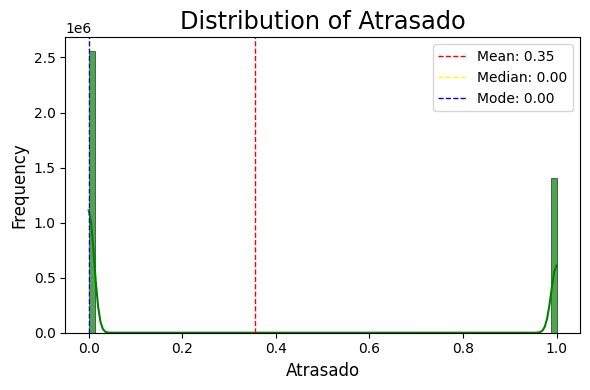

In [10]:
visualize_y(df, y_col_name='Atrasado')

### Separando X e Y

Aqui separaremos as features (X) da variável alvo (Y).

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['Atrasado']),
    df['Atrasado'],
    test_size=0.3,
    random_state=42,
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2772258, 5), (1188111, 5), (2772258,), (1188111,))

In [12]:
X_train.head()

,Empresa Aérea,Aeródromo Origem,Aeródromo Destino,Distância (m),Data Hora Voo
539539,TAM,SBSG,SBGR,2296000,2020-01-20 12:45:00
3459606,GLO,SBSP,SBCF,524000,2025-03-09 19:25:00
483225,AZU,SBFZ,SBRF,627000,2018-12-27 06:50:00
355420,ONE,SBGR,SBRF,2101000,2018-10-29 23:20:00
1508305,TAM,SBGR,SBFZ,2347000,2022-07-10 09:30:00


In [13]:
y_train.head()

539539     0
3459606    0
483225     0
355420     0
1508305    0
Name: Atrasado, dtype: int8

### Modelagem

Para o processo de modelagem, decidimos usar a moderna biblioteca [Oracle AutoMLx](https://docs.oracle.com/en-us/iaas/tools/automlx/latest/latest/index.html), que automatiza os processos de `Seleção de Algoritmo`, `Sampling Adaptativo`, `Seleção de Features` e `Ajuste de Hiperparâmetros`, resultando num processo facilitado e com melhores métricas no modelo final.  

In [14]:
init(engine='local')

#### Experimentação - Avaliação de Pipelines

Nesta etapa, experimentamos diferentes configurações de `Pipeline` do Oracle AutoMLx com o objetivo de **compreender o comportamento do nosso dataset em tarefas de classificação**, bem como **avaliar o impacto de diferentes escolhas de modelagem** (tipo de modelo, amostragem, seleção de features e tuning).

Cada experimento foi desenhado para responder a uma **pergunta específica**, evitando combinações arbitrárias e permitindo interpretações claras dos resultados.

---

##### 1. Baseline Linear — Regressão Logística

Geramos inicialmente um modelo baseline de **Regressão Logística**, com pré-processamento automático habilitado e sem técnicas de reamostragem.

Este experimento tem como objetivos:
- Avaliar o quão bem um modelo **linear** consegue capturar o padrão de atrasos nos voos;
- Servir como **âncora de interpretabilidade**, uma vez que modelos lineares facilitam a análise do efeito marginal das variáveis;
- Estabelecer um **limite inferior de performance** para comparação com modelos mais complexos.

---

##### 2. Baseline Não Linear — LightGBM sem Tuning

Em seguida, treinamos um modelo **LightGBM** utilizando as configurações padrão, sem ajuste de hiperparâmetros e sem amostragem adaptativa.

Este experimento busca:
- Avaliar o ganho de performance ao introduzir **não linearidades e interações entre variáveis**;
- Estabelecer um **baseline robusto de modelos baseados em árvores**;
- Comparar diretamente com a Regressão Logística para verificar se o problema exige maior capacidade de modelagem.

---

##### 3. Impacto da Amostragem Adaptativa

Mantendo o LightGBM sem tuning, ativamos a funcionalidade de **adaptive sampling** do AutoMLx.

O objetivo deste experimento é:
- Verificar se a leve desproporção entre as classes (≈65% / 35%) se beneficia de técnicas de reamostragem;
- Avaliar o impacto da amostragem adaptativa na **capacidade discriminativa global** do modelo (ROC AUC);
- Identificar possíveis trade-offs entre recall da classe minoritária e calibração de probabilidades.

---

##### 4. Forçando Features Relevantes ao Domínio

Neste experimento, utilizamos novamente o LightGBM, mas **forçando a inclusão de variáveis consideradas críticas pelo conhecimento de domínio**, como:
- Empresa Aérea  
- Aeródromo de Origem  
- Aeródromo de Destino  

A motivação é:
- Avaliar se o mecanismo automático de seleção de features do AutoMLx está descartando informações relevantes;
- Testar se a imposição dessas variáveis melhora a capacidade de generalização do modelo;
- Validar a confiança no processo automatizado de feature selection.

---

##### 5. Tuning Leve de Hiperparâmetros do LightGBM

Aqui realizamos um **ajuste leve de hiperparâmetros** do LightGBM, visando comparar o modelo ajustado com o modelo baseline `2`.  

Este experimento busca responder:
- Se pequenos ajustes em hiperparâmetros estruturais (como profundidade, número de folhas e taxa de aprendizado) trazem ganhos mensuráveis;
- Se o custo computacional do tuning é justificável dado o grande volume de dados;
- Se as configurações padrão já se encontram próximas do ótimo para este problema.

---

##### 6. Modelo de Sanidade — Naive Bayes Gaussiano

Por fim, treinamos um modelo **Gaussian Naive Bayes**, que assume independência condicional entre as variáveis.

Este experimento não visa competir em performance, mas sim:
- Atuar como um **teste de sanidade**;
- Avaliar se o problema pode ser explicado por relações estatísticas simples;
- Confirmar a necessidade de modelos capazes de capturar interações complexas.

---

Ao final desses experimentos, temos uma visão clara sobre:
- A complexidade intrínseca do problema;
- O impacto real de técnicas de automação (sampling, feature selection, tuning);
- O melhor equilíbrio entre performance, custo computacional e interpretabilidade.

In [16]:
PIPELINE_CONFIGS = {
    # --------------------------------------------------
    # 1) Linear baseline (interpretability anchor)
    # --------------------------------------------------
    "01_baseline_logreg": {
        "task": "classification",
        "model_list": ["LogisticRegression"],
        "preprocessing": True,
        "adaptive_sampling": False,
        "score_metric": "roc_auc",
    },

    # --------------------------------------------------
    # 2) Tree baseline (no tuning, full data)
    # --------------------------------------------------
    "02_baseline_lgbm": {
        "task": "classification",
        "model_list": ["LGBMClassifier"],
        "n_algos_tuned": 1,
        "max_tuning_trials": 1,
        "preprocessing": True,
        "adaptive_sampling": False,
        "score_metric": "roc_auc",
    },

    # --------------------------------------------------
    # 3) Effect of adaptive sampling
    # --------------------------------------------------
    "03_lgbm_with_sampling": {
        "task": "classification",
        "model_list": ["LGBMClassifier"],
        "n_algos_tuned": 1,
        "max_tuning_trials": 1,
        "adaptive_sampling": True,
        "score_metric": "roc_auc",
    },

    # --------------------------------------------------
    # 4) Force domain-important features
    # (tests AutoMLx feature selection behavior)
    # --------------------------------------------------
    "04_lgbm_forced_features": {
        "task": "classification",
        "model_list": ["LGBMClassifier"],
        "n_algos_tuned": 1,
        "max_tuning_trials": 1,
        "min_features": [
            "Empresa Aérea",
            "Aeródromo Origem",
            "Aeródromo Destino",
        ],
        "adaptive_sampling": False,
        "score_metric": "roc_auc",
    },

    # --------------------------------------------------
    # 5) Light Hyperparameter tuning
    # --------------------------------------------------
    "05_lgbm_light_tuning": {
        "task": "classification",
        "model_list": ["LGBMClassifier"],
        "adaptive_sampling": False,
        "max_tuning_trials": 5,
        "score_metric": "roc_auc",
    },

    # --------------------------------------------------
    # 6) Naive Bayes sanity check
    # --------------------------------------------------
    "06_nb_sanity": {
        "task": "classification",
        "model_list": ["GaussianNB"],
        "preprocessing": True,
        "adaptive_sampling": False,
        "score_metric": "roc_auc",
    },
}


##### Realizando experimentação

Esta funcionalidade permite realizar a experimentação de pipelines conforme as configurações contidas no dicionário `PIPELINE_CONFIGS`. Após a experimentação, os modelos são salvos em ./models/experimental_models.  

In [17]:
# Código comentado por segurança
# Descomente a linha abaixo para executar a experimentação dos pipelines AutoMLx

# experimental_models = run_experiments(pipeline_configs=PIPELINE_CONFIGS, X_train=X_train, y_train=y_train)

##### Carregar Modelos Experimentais

Esta funcionalidade permite carregar modelos experimentais previamente treinados e salvos a partir de um dicionário `PIPELINE_CONFIGS`.

In [18]:
experimental_models = load_experimental_models(PIPELINE_CONFIGS)

Carregando modelos experimentais...

🔄 Carregando modelo: 01_baseline_logreg
🔄 Carregando modelo: 02_baseline_lgbm
🔄 Carregando modelo: 03_lgbm_with_sampling
🔄 Carregando modelo: 04_lgbm_forced_features
🔄 Carregando modelo: 05_lgbm_light_tuning
🔄 Carregando modelo: 06_nb_sanity

🏁 Modelos carregados com sucesso!


##### Avaliando Modelos Experimentais


📊 Experiment results: 01_baseline_logreg

=> Roc_auc score em dados de teste: 0.5998176881321253

=> Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.71      0.53      0.61    766532
           1       0.42      0.61      0.50    421579

    accuracy                           0.56   1188111
   macro avg       0.56      0.57      0.55   1188111
weighted avg       0.61      0.56      0.57   1188111

=> Matriz de Confusão:


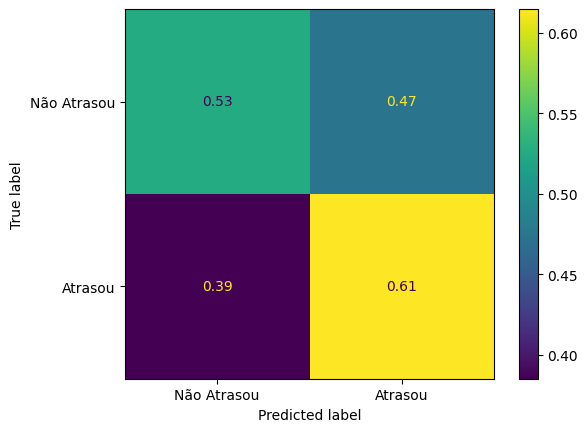


📊 Experiment results: 02_baseline_lgbm

=> Roc_auc score em dados de teste: 0.6864675820772784

=> Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.76      0.62      0.68    766532
           1       0.48      0.65      0.55    421579

    accuracy                           0.63   1188111
   macro avg       0.62      0.63      0.62   1188111
weighted avg       0.66      0.63      0.64   1188111

=> Matriz de Confusão:


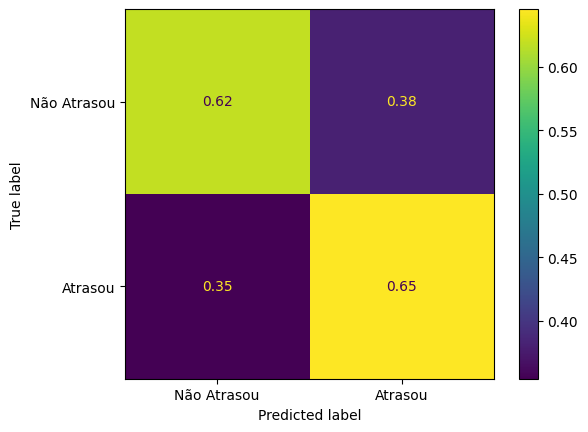


📊 Experiment results: 03_lgbm_with_sampling

=> Roc_auc score em dados de teste: 0.6867370626546669

=> Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.76      0.62      0.69    766532
           1       0.48      0.64      0.55    421579

    accuracy                           0.63   1188111
   macro avg       0.62      0.63      0.62   1188111
weighted avg       0.66      0.63      0.64   1188111

=> Matriz de Confusão:


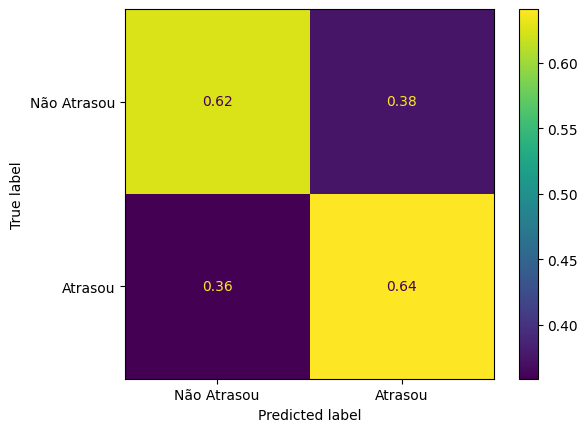


📊 Experiment results: 04_lgbm_forced_features

=> Roc_auc score em dados de teste: 0.6864675820772784

=> Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.76      0.62      0.68    766532
           1       0.48      0.65      0.55    421579

    accuracy                           0.63   1188111
   macro avg       0.62      0.63      0.62   1188111
weighted avg       0.66      0.63      0.64   1188111

=> Matriz de Confusão:


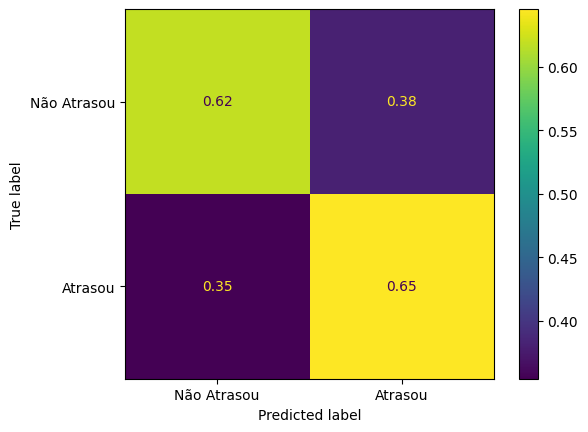


📊 Experiment results: 05_lgbm_light_tuning

=> Roc_auc score em dados de teste: 0.6986298209048363

=> Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.77      0.64      0.70    766532
           1       0.49      0.64      0.56    421579

    accuracy                           0.64   1188111
   macro avg       0.63      0.64      0.63   1188111
weighted avg       0.67      0.64      0.65   1188111

=> Matriz de Confusão:


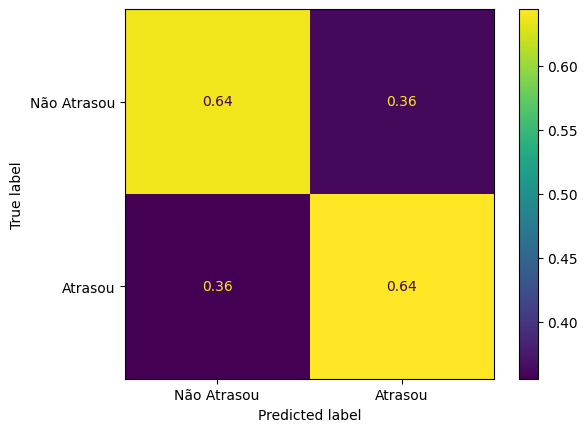


📊 Experiment results: 06_nb_sanity

=> Roc_auc score em dados de teste: 0.6010541892590946

=> Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.76      0.28      0.41    766532
           1       0.39      0.84      0.53    421579

    accuracy                           0.48   1188111
   macro avg       0.58      0.56      0.47   1188111
weighted avg       0.63      0.48      0.45   1188111

=> Matriz de Confusão:


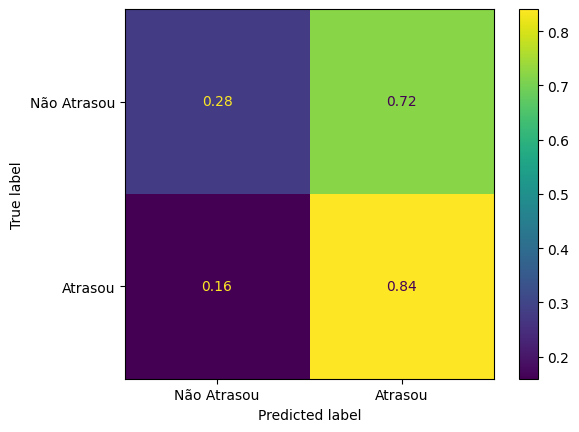

In [19]:
evaluate_experimental_models(
    experimental_models=experimental_models,
    X_test=X_test,
    y_test=y_test,
)

##### Insights

| Experimento           | ROC AUC    | Principal insight                                   |
| --------------------- | ---------- | --------------------------------------------------- |
| baseline_logreg       | ~0.600     | Modelos lineares são insuficientes                  |
| baseline_lgbm         | ~0.686     | Estrutura não linear é essencial                   |
| lgbm_with_sampling    | ~0.687     | A amostragem adaptativa tem efeito desprezível     |
| lgbm_forced_features  | ~0.686     | A seleção automática de features do AutoMLx é confiável |
| lgbm_light_tuning     | **~0.699** | Tuning leve gera ganhos reais de performance        |
| nb_sanity             | ~0.601     | O sinal não é trivial                               |

Os experimentos realizados fornecem uma visão clara sobre a natureza do problema e sobre as escolhas mais adequadas de modelagem.

- Em primeiro lugar, a comparação entre a Regressão Logística e os modelos baseados em árvores evidencia que **modelos lineares não são suficientes** para capturar a complexidade do fenômeno de atraso de voos. O ganho expressivo de ROC AUC ao utilizar o LightGBM indica a presença de **relações não lineares e interações relevantes** entre variáveis categóricas, numéricas e temporais.

- A avaliação do uso de **adaptive sampling** mostrou impacto praticamente nulo na performance global do modelo. Isso sugere que a leve desproporção entre as classes (aproximadamente 65% / 35%) não compromete o aprendizado, e que o LightGBM consegue lidar adequadamente com a distribuição original dos dados, tornando desnecessária a introdução de técnicas adicionais de reamostragem.

- Ao forçar a inclusão de variáveis consideradas críticas pelo conhecimento de domínio, não observamos melhorias de desempenho. Esse resultado indica que o mecanismo automático de seleção de features do Oracle AutoMLx é confiável e não está descartando informações relevantes, reforçando a robustez da abordagem automatizada.

- O ajuste leve de hiperparâmetros apresentou ganhos consistentes de performance, elevando o ROC AUC para aproximadamente 0.70. Esse resultado demonstra que, mesmo em um dataset de grande escala, **tuning controlado e bem delimitado** pode trazer benefícios reais, sem incorrer em custos computacionais excessivos ou risco elevado de overfitting.

- Por fim, o desempenho do modelo Naive Bayes, semelhante ao da Regressão Logística e significativamente inferior ao LightGBM, confirma que o problema não é trivial e não pode ser explicado por relações estatísticas simples entre as variáveis. A capacidade de modelar interações complexas é fundamental para alcançar bons resultados.

- De forma geral, os experimentos indicam que **modelos baseados em árvores, com tuning leve e sem reamostragem**, oferecem o melhor equilíbrio entre performance, robustez e custo computacional para este problema.


#### Aprofundando Busca

Nesta etapa, experimentamos um `Pipeline` do Oracle AutoMLx para cada tipo de modelo **não-linear** existente com o objetivo de **encontrar o modelo mais performático** para ser utilizado em produção, bem como **avaliar o impacto do uso de diferentes modelos**.  

Experimentamos os modelos:
- LightGBM
- Random Forest
- Extra Trees
- XGBoost  

Num primeiro momento, testamos a definição de um `search_space` e `max_tuning_trials`, para posteriormente testarmos os mesmos modelos usando força bruta e verificarmos se algum ganho considerável se dá com o uso de força bruta.  

Embora neste projeto usaremos o melhor modelo encontrado, que provavelmente será encontrado utilizando força bruta, este conhecimento será útil para modelagens futuras.

##### Realizando Experimentação

In [20]:
PIPELINE_CONFIGS_FINAL = {
    # --------------------------------------------------
    # 1) Tuned LightGBM (reference champion)
    # --------------------------------------------------
    "07_lgbm_competitive": {
        "task": "classification",
        "model_list": ["LGBMClassifier"],
        "n_algos_tuned": 1,
        "adaptive_sampling": False,
        "search_space": {
            "LGBMClassifier": {
                "num_leaves": {
                    "range": [31, 255],
                    "type": "discrete",
                },
                "max_depth": {
                    "range": [6, 20],
                    "type": "discrete",
                },
                "learning_rate": {
                    "range": [0.01, 0.15],
                    "type": "continuous",
                },
                "min_child_samples": {
                    "range": [20, 200],
                    "type": "discrete",
                },
            }
        },
        "max_tuning_trials": 40,
        "score_metric": "roc_auc",
    },

    # --------------------------------------------------
    # 2) Random Forest (strong bagging baseline)
    # --------------------------------------------------
    "08_rf_competitive": {
        "task": "classification",
        "model_list": ["RandomForestClassifier"],
        "n_algos_tuned": 1,
        "adaptive_sampling": False,
        "search_space": {
            "RandomForestClassifier": {
                "n_estimators": {
                    "range": [200, 800],
                    "type": "discrete",
                },
                "max_depth": {
                    "range": [8, 30],
                    "type": "discrete",
                },
                "min_samples_leaf": {
                    "range": [10, 100],
                    "type": "discrete",
                },
                "max_features": {
                    "range": [0.3, 1.0],
                    "type": "continuous",
                },
            }
        },
        "max_tuning_trials": 25,
        "score_metric": "roc_auc",
    },

    # --------------------------------------------------
    # 3) Extra Trees (high-variance interaction hunter)
    # --------------------------------------------------
    "09_extra_trees_competitive": {
        "task": "classification",
        "model_list": ["ExtraTreesClassifier"],
        "n_algos_tuned": 1,
        "adaptive_sampling": False,
        "search_space": {
            "ExtraTreesClassifier": {
                "n_estimators": {
                    "range": [300, 1000],
                    "type": "discrete",
                },
                "max_depth": {
                    "range": [8, 30],
                    "type": "discrete",
                },
                "min_samples_leaf": {
                    "range": [10, 100],
                    "type": "discrete",
                },
                "max_features": {
                    "range": [0.3, 1.0],
                    "type": "continuous",
                },
            }
        },
        "max_tuning_trials": 25,
        "score_metric": "roc_auc",
    },

    # --------------------------------------------------
    # 4) XGBoost (if available in your AutoMLx version)
    # --------------------------------------------------
    "10_xgb_competitive": {
        "task": "classification",
        "model_list": ["XGBClassifier"],
        "n_algos_tuned": 1,
        "adaptive_sampling": False,
        "search_space": {
            "XGBClassifier": {
                "max_depth": {
                    "range": [5, 15],
                    "type": "discrete",
                },
                "learning_rate": {
                    "range": [0.01, 0.2],
                    "type": "continuous",
                },
                "subsample": {
                    "range": [0.6, 1.0],
                    "type": "continuous",
                },
                "colsample_bytree": {
                    "range": [0.6, 1.0],
                    "type": "continuous",
                },
            }
        },
        "max_tuning_trials": 30,
        "score_metric": "roc_auc",
    },
}

In [21]:
PIPELINE_CONFIGS_FINAL_BRUTE_FORCE = {
    # --------------------------------------------------
    # 1) Tuned LightGBM (reference champion)
    # --------------------------------------------------
    "11_lgbm_competitive_brute_force": {
        "task": "classification",
        "model_list": ["LGBMClassifier"],
        "n_algos_tuned": 1,
        "adaptive_sampling": False,
        "score_metric": "roc_auc",
    },

    # --------------------------------------------------
    # 2) Random Forest (strong bagging baseline)
    # --------------------------------------------------
    "12_rf_competitive_brute_force": {
        "task": "classification",
        "model_list": ["RandomForestClassifier"],
        "n_algos_tuned": 1,
        "adaptive_sampling": False,
        "score_metric": "roc_auc",
    },

    # --------------------------------------------------
    # 3) Extra Trees (high-variance interaction hunter)
    # --------------------------------------------------
    "13_extra_trees_competitive_brute_force": {
        "task": "classification",
        "model_list": ["ExtraTreesClassifier"],
        "n_algos_tuned": 1,
        "adaptive_sampling": False,
        "score_metric": "roc_auc",
    },

    # --------------------------------------------------
    # 4) XGBoost (if available in your AutoMLx version)
    # --------------------------------------------------
    "14_xgb_competitive_brute_force": {
        "task": "classification",
        "model_list": ["XGBClassifier"],
        "n_algos_tuned": 1,
        "adaptive_sampling": False,
        "score_metric": "roc_auc",
    },
}

In [ ]:
# Código comentado por segurança
# Descomente a linha abaixo para executar a experimentação dos pipelines AutoMLx

# experimental_models_final = run_experiments(pipeline_configs=PIPELINE_CONFIGS_FINAL, X_train=X_train, y_train=y_train, export_models=False)

In [23]:
# Código comentado por segurança
# Descomente a linha abaixo para executar a experimentação dos pipelines AutoMLx

# experimental_models_final_brute_force = run_experiments(pipeline_configs=PIPELINE_CONFIGS_FINAL_BRUTE_FORCE, X_train=X_train, y_train=y_train, export_models=False)

##### Carregar Modelos

In [24]:
experimental_models_final = load_experimental_models(PIPELINE_CONFIGS_FINAL)

Carregando modelos experimentais...

🔄 Carregando modelo: 07_lgbm_competitive
🔄 Carregando modelo: 08_rf_competitive
🔄 Carregando modelo: 09_extra_trees_competitive
🔄 Carregando modelo: 10_xgb_competitive

🏁 Modelos carregados com sucesso!


In [25]:
experimental_models_final_brute_force = load_experimental_models(PIPELINE_CONFIGS_FINAL_BRUTE_FORCE)

Carregando modelos experimentais...

🔄 Carregando modelo: 11_lgbm_competitive_brute_force
🔄 Carregando modelo: 12_rf_competitive_brute_force
🔄 Carregando modelo: 13_extra_trees_competitive_brute_force
🔄 Carregando modelo: 14_xgb_competitive_brute_force

🏁 Modelos carregados com sucesso!


##### Avaliação Final


📊 Experiment results: 07_lgbm_competitive

=> Roc_auc score em dados de teste: 0.6942820751891283

=> Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.76      0.63      0.69    766532
           1       0.49      0.64      0.56    421579

    accuracy                           0.64   1188111
   macro avg       0.63      0.64      0.62   1188111
weighted avg       0.67      0.64      0.64   1188111

=> Matriz de Confusão:


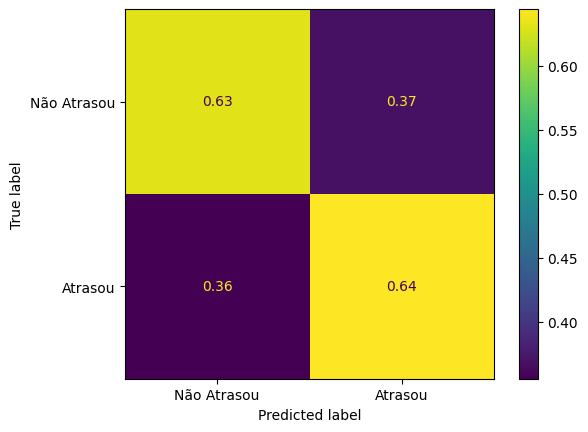


📊 Experiment results: 08_rf_competitive

=> Roc_auc score em dados de teste: 0.6962791783082214

=> Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.77      0.63      0.69    766532
           1       0.49      0.65      0.56    421579

    accuracy                           0.64   1188111
   macro avg       0.63      0.64      0.63   1188111
weighted avg       0.67      0.64      0.65   1188111

=> Matriz de Confusão:


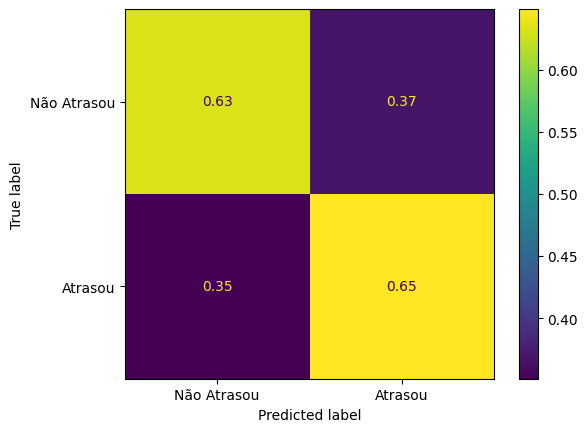


📊 Experiment results: 09_extra_trees_competitive

=> Roc_auc score em dados de teste: 0.6797620980754034

=> Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.76      0.59      0.66    766532
           1       0.47      0.67      0.55    421579

    accuracy                           0.62   1188111
   macro avg       0.62      0.63      0.61   1188111
weighted avg       0.66      0.62      0.62   1188111

=> Matriz de Confusão:


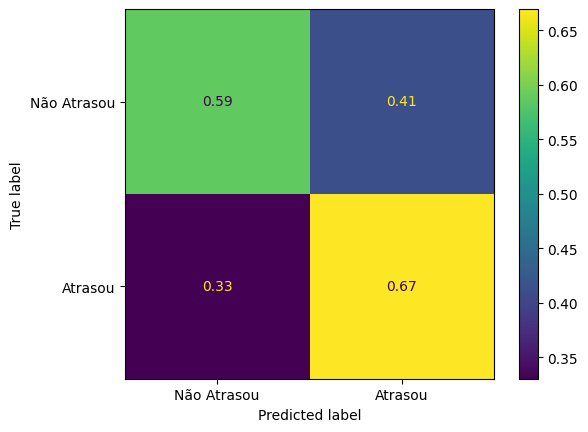


📊 Experiment results: 10_xgb_competitive

=> Roc_auc score em dados de teste: 0.7050870670088976

=> Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.77      0.65      0.71    766532
           1       0.50      0.64      0.56    421579

    accuracy                           0.65   1188111
   macro avg       0.64      0.65      0.64   1188111
weighted avg       0.67      0.65      0.66   1188111

=> Matriz de Confusão:


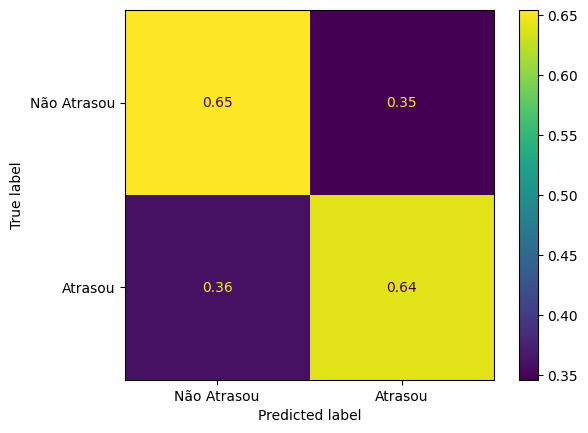

In [26]:
evaluate_experimental_models(
    experimental_models=experimental_models_final,
    X_test=X_test,
    y_test=y_test,)


📊 Experiment results: 11_lgbm_competitive_brute_force

=> Roc_auc score em dados de teste: 0.7088265561247066

=> Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.77      0.65      0.70    766532
           1       0.50      0.65      0.57    421579

    accuracy                           0.65   1188111
   macro avg       0.64      0.65      0.64   1188111
weighted avg       0.68      0.65      0.66   1188111

=> Matriz de Confusão:


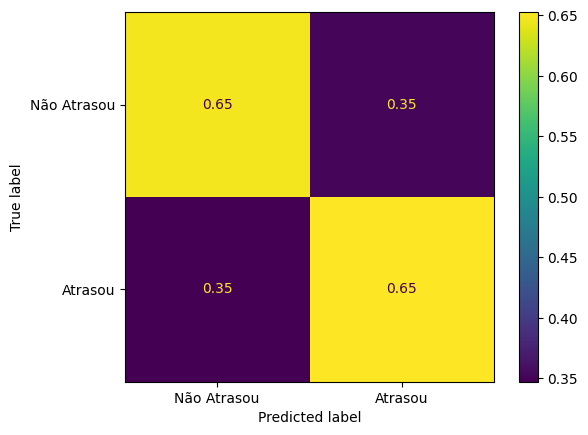


📊 Experiment results: 12_rf_competitive_brute_force

=> Roc_auc score em dados de teste: 0.6968540493462008

=> Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.77      0.63      0.69    766532
           1       0.49      0.65      0.56    421579

    accuracy                           0.64   1188111
   macro avg       0.63      0.64      0.63   1188111
weighted avg       0.67      0.64      0.65   1188111

=> Matriz de Confusão:


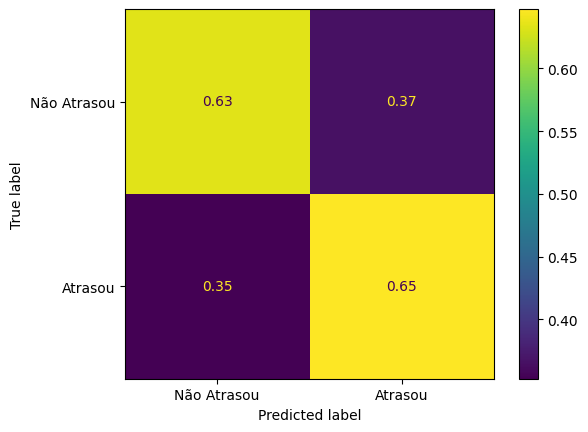


📊 Experiment results: 13_extra_trees_competitive_brute_force

=> Roc_auc score em dados de teste: 0.6948164432398561

=> Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.77      0.62      0.68    766532
           1       0.49      0.66      0.56    421579

    accuracy                           0.63   1188111
   macro avg       0.63      0.64      0.62   1188111
weighted avg       0.67      0.63      0.64   1188111

=> Matriz de Confusão:


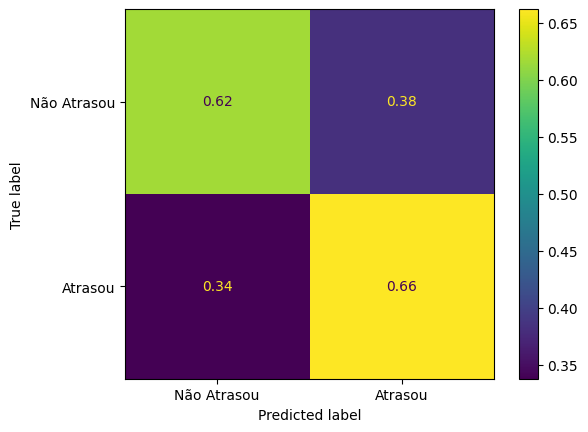


📊 Experiment results: 14_xgb_competitive_brute_force

=> Roc_auc score em dados de teste: 0.7031237525152265

=> Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.77      0.64      0.70    766532
           1       0.50      0.65      0.56    421579

    accuracy                           0.64   1188111
   macro avg       0.63      0.65      0.63   1188111
weighted avg       0.67      0.64      0.65   1188111

=> Matriz de Confusão:


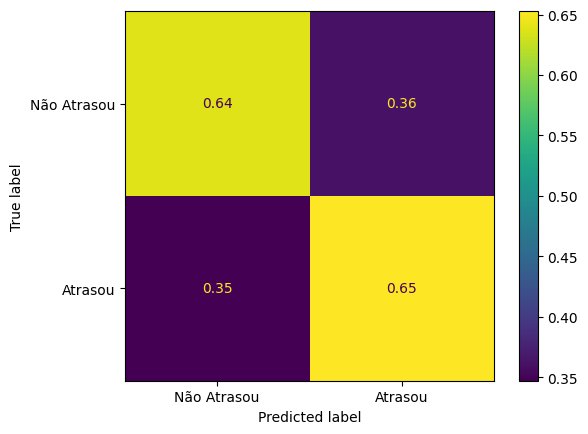

In [27]:
evaluate_experimental_models(
    experimental_models=experimental_models_final_brute_force,
    X_test=X_test,
    y_test=y_test,)

#### Pipeline Genérico

Aqui experimentamos um `pipeline` genérico, informando apenas a `task` e a `score_metric`.  
Nosso objetivo é conferir a capacidade do [Oracle AutoMLx](https://docs.oracle.com/en-us/iaas/tools/automlx/latest/latest/index.html) de automatizar o processo que fizemos explicitamente nas etapas anteriores.  

In [28]:
estimator_automl = automlx.Pipeline(task='classification', score_metric='roc_auc', random_state=7) # type: ignore
estimator_automl.fit(X_train, y_train)

[2026-01-13 19:41:01,008] [automlx.interface] Dataset shape: (2772258,5)
[2026-01-13 19:41:01,270] [automlx.data_transform] Running preprocessing. Number of features: 6
[2026-01-13 19:41:02,277] [automlx.data_transform] Preprocessing completed. Took 1.007 secs
[2026-01-13 19:41:02,307] [automlx.process] Running Model Generation
[2026-01-13 19:41:02,351] [automlx] Provided model (TorchMLPClassifier) is not supported.Supported models are: ['CatBoostClassifier', 'LGBMClassifier', 'SVC', 'AdaBoostClassifier', 'DecisionTreeClassifier', 'ExtraTreesClassifier', 'GaussianNB', 'GradientBoostingClassifier', 'KNeighborsClassifier', 'LinearSVC', 'LogisticRegressionClassifier', 'RandomForestClassifier', 'XGBClassifier']
[2026-01-13 19:41:02,353] [automlx.process] KNeighborsClassifier is disabled. The KNeighborsClassifier model is only recommended for datasets with less than 10000 samples and 1000 features.
[2026-01-13 19:41:02,354] [automlx.process] SVC is disabled. The SVC model is only recommende

[19:41:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Number of positive: 1991, number of negative: 2009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 803
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502250 -> initscore=0.009000
[LightGBM] [Info] Start training from score 0.009000
[2026-01-13 19:41:09,575] [automlx.model_selection] Model Selection completed - Took 7.135 sec - Selected models: [['XGBClassifier']]
[2026-01-13 19:41:09,647] [automlx.adaptive_sampling] Running Adaptive Sampling. Dataset shape: (100000,19).


[19:41:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:49:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[2026-01-13 19:41:12,274] [automlx.trials] Adaptive Sampling completed - Took 2.6266 sec.
[2026-01-13 19:41:12,509] [automlx.feature_selection] Starting feature ranking for XGBClassifier


[19:41:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_la

[2026-01-13 19:41:24,332] [automlx.feature_selection] Feature Selection completed. Took 11.848 secs.
[2026-01-13 19:41:24,413] [automlx.trials] Running Model Tuning for ['XGBClassifier']


[19:41:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:41:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[19:50:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_la

[2026-01-13 19:44:27,147] [automlx.trials] Best parameters for XGBClassifier: {'learning_rate': 0.1, 'min_child_weight': 18, 'max_depth': 6, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 256, 'use_label_encoder': False}
[2026-01-13 19:44:27,150] [automlx.trials] Model Tuning completed. Took: 182.738 secs
[2026-01-13 19:44:29,309] [automlx.interface] Re-fitting pipeline
[2026-01-13 19:44:29,330] [automlx.final_fit] Skipping updating parameter seed, already fixed by FinalFit_598078ff-f


[19:44:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[2026-01-13 19:44:38,248] [automlx.interface] AutoMLx completed.


##### Resultado do Pipeline Genérico


📊 Experiment results: estimator_automl

=> Roc_auc score em dados de teste: 0.7077901737219955

=> Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.77      0.64      0.70    766532
           1       0.50      0.66      0.57    421579

    accuracy                           0.65   1188111
   macro avg       0.64      0.65      0.63   1188111
weighted avg       0.68      0.65      0.65   1188111

=> Matriz de Confusão:


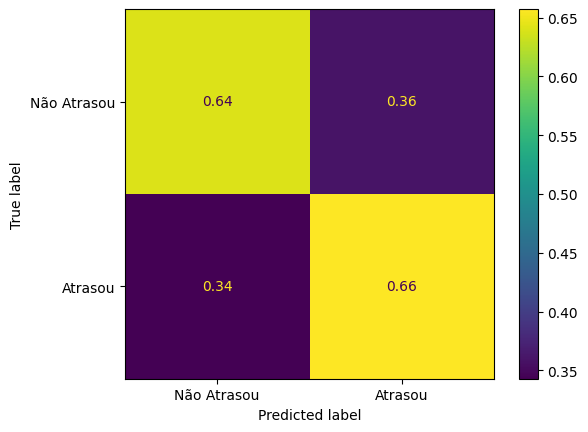

In [29]:
print(f"\n{'='*60}")
print(f"📊 Experiment results: {'estimator_automl'}")
print(f"{'='*60}\n")

evaluate_model(estimator_automl, X_test, y_test)

### Melhor Modelo

Em nossos experimentos, encontramos que o melhor modelo experimental foi o modelo `11_lgbm_competitive_brute_force`, com um **ROC_AUC** de **~0.709**, o qual utilizaremos em produção.

In [ ]:
best_estimator = experimental_models_final_brute_force['11_lgbm_competitive_brute_force']

Ao experimentar um pipeline genérico, permitindo ao AutoML experimentar sozinho as melhores estratégias, obtivemos um modelo LightGBM quase idêntico cujo **ROC_AUC** atingiu **~0.708**. Um resultado impressionante que ressalta a confiabilidade do Oracle AutoMLx.

#### Sumário das Experimentações

Abaixo o sumário de todo o processo de experimentação. O sumário inclui:  
- O processo de teste de hipóteses (modelos 01 a 06)  

- O processo de aprofundamento das buscas
    - Modelos 07 a 10: com `search_space` definido.
    - Modelos 11 a 14: com uso de força bruta.
- O resultado do modelo gerado automaticamente pelo AutoML.

| Experimento                               | ROC AUC    | Principal insight                                                                 |
| ---------------------------------------- | ---------- | --------------------------------------------------------------------------------- |
| 01_baseline_logreg                           | ~0.600     | Modelos lineares são insuficientes para capturar a complexidade do problema        |
| 02_baseline_lgbm                             | ~0.686     | Estrutura não linear é essencial para melhor discriminação                         |
| 03_lgbm_with_sampling                        | ~0.687     | A amostragem adaptativa apresenta efeito desprezível neste cenário                 |
| 04_lgbm_forced_features                      | ~0.686     | A seleção automática de features do AutoMLx mostrou-se confiável                   |
| 05_lgbm_light_tuning                         | ~0.699     | Tuning leve de hiperparâmetros gera ganhos reais de performance                    |
| 06_nb_sanity                                 | ~0.601     | O sinal não é trivial e requer modelos capazes de capturar interações              |
|                                          |            |                                                                                   |
| 07_lgbm_competitive                       | ~0.694     | LightGBM competitivo confirma boa capacidade com tuning direcionado               |
| 08_rf_competitive                         | ~0.696     | Random Forest apresenta performance consistente em dados tabulares                |
| 09_extra_trees_competitive                | ~0.680     | Extra Trees mostra maior variância e menor estabilidade neste problema             |
| 10_xgb_competitive                        | ~0.705     | XGBoost competitivo demonstra forte capacidade de generalização                   |
|                                          |            |                                                                                   |
| 11_lgbm_competitive_brute_force ⭐         | **~0.709** | Melhor modelo experimental: tuning extensivo de LightGBM maximiza performance      |
| 12_rf_competitive_brute_force             | ~0.697     | Brute force não trouxe ganhos relevantes para Random Forest                        |
| 13_extra_trees_competitive_brute_force    | ~0.695     | Ajuste extensivo melhora Extra Trees, mas permanece abaixo dos líderes             |
| 14_xgb_competitive_brute_force            | ~0.703     | XGBoost com brute force mantém alta performance, porém inferior ao melhor LGBM     |
|                                          |            |                                                                                   |
| pipeline_automl_generico                  | **~0.708**     | AutoMLx identifica automaticamente um LightGBM quase ótimo, com mínima intervenção |


### Análise do Processo de otimização do AutoMLx

Nesta seção analisamos o processo de otimização executado pelo AutoMLx de forma a compreender melhor o processo de modelagem que ele executa.  

Para um estudo mais aprofundado da biblioteca, utilizaremos o estimador genérico `estimator_automl` gerado anteriormente para podermos observar o processo de **Seleção de Algoritmo** e **Sampling Adaptativo**, não efetuado no melhor modelo lgbm.

Para mais informações acesse:
- [Documentação do AutoMLx](https://docs.oracle.com/en-us/iaas/tools/automlx/latest/latest/index.html)  
- [Demo: AutoMLx Classification](https://github.com/oracle-samples/automlx/blob/main/demos/OracleAutoMLx_Classification.ipynb)

#### Sumário

Sumário dos experimentos executados pelo AutoMLx.

In [31]:
estimator_automl.print_summary()

""
"(2772258, 5)"
None
"HoldoutSplit(Shuffle=True, Seed=7, train portion=0.80)"
roc_auc
XGBClassifier
"{'learning_rate': 0.1, 'min_child_weight': 18, 'max_depth': 6, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 256, 'use_label_encoder': False}"
25.3.1
"3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:16:04) [GCC 11.2.0]"


Step,# Samples,# Features,Algorithm,Hyperparameters,Score (roc_auc),All Metrics,Runtime (Seconds),Memory Usage (GB),Finished
Model Selection,4000,18,XGBClassifier,"{'learning_rate': 0.1, 'min_child_weight': 1, 'max_depth': 3, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 100, 'use_label_encoder': False}",0.6312,{'roc_auc': 0.6312485245219451},0.2603,2.0985,Tue Jan 13 19:41:08 2026
Model Selection,4000,18,CatBoostClassifier,"{'iterations': 235, 'learning_rate': 0.787168, 'leaf_estimation_method': 'Newton', 'colsample_bylevel': 0.096865, 'depth': 3, 'l2_leaf_reg': 2.567326, 'feature_border_type': 'UniformAndQuantiles', 'model_size_reg': 3.85132, 'leaf_estimation_iterations': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'auto_class_weights': 'SqrtBalanced', 'allow_writing_files': False, 'allow_const_label': True}",0.6275,{'roc_auc': 0.6274793032942674},0.3056,2.1165,Tue Jan 13 19:41:07 2026
Model Selection,4000,18,LGBMClassifier,"{'num_leaves': 31, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'min_child_weight': 0.001, 'max_depth': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'n_estimators': 100, 'class_weight': 'balanced'}",0.6266,{'roc_auc': 0.6266310284532188},1.2444,2.0954,Tue Jan 13 19:41:09 2026
Model Selection,4000,18,RandomForestClassifier,"{'n_estimators': 100, 'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 0.777777778, 'class_weight': 'balanced'}",0.5891,{'roc_auc': 0.5890988680332429},1.1926,2.1003,Tue Jan 13 19:41:09 2026
Model Selection,4000,18,ExtraTreesClassifier,"{'n_estimators': 100, 'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 0.777777778, 'class_weight': 'balanced', 'criterion': 'gini'}",0.5857,{'roc_auc': 0.5856777595941085},0.8045,2.1067,Tue Jan 13 19:41:08 2026
Model Selection,4000,18,DecisionTreeClassifier,"{'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 1.0, 'class_weight': None}",0.5355,{'roc_auc': 0.5354834966529155},0.1008,2.0862,Tue Jan 13 19:41:07 2026
Model Selection,4000,18,LogisticRegressionClassifier,"{'C': 1.0, 'solver': 'liblinear', 'class_weight': 'balanced'}",0.5188,{'roc_auc': 0.518768080858198},0.1413,2.0863,Tue Jan 13 19:41:08 2026
Model Selection,4000,18,GaussianNB,{},0.5188,{'roc_auc': 0.518768080858198},0.0718,2.0862,Tue Jan 13 19:41:07 2026
Adaptive Sampling,80000,18,AdaptiveSamplingStage_XGBClassifier,"{'learning_rate': 0.1, 'min_child_weight': 1, 'max_depth': 3, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 100, 'use_label_encoder': False}",0.6811,{'roc_auc': 0.6810822180335758},526.1849,2.0865,Tue Jan 13 19:41:11 2026
Adaptive Sampling,64438,18,AdaptiveSamplingStage_XGBClassifier,"{'learning_rate': 0.1, 'min_child_weight': 1, 'max_depth': 3, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 100, 'use_label_encoder': False}",0.6796,{'roc_auc': 0.6795957189162873},526.3988,2.0869,Tue Jan 13 19:41:11 2026


#### Visualizações

Cada experimento (`trial`) nos gráficos abaixo é uma linha em um dataframe que contém:  
Algoritmo, Número de Amostras, Número de Features, Hiperparâmetros, Score, Tempo de Execução, Uso de Memória e Etapa.  

Para saber mais:
- [Acesse as funções](./utils/plot_automl_results.py)  

- Utilize o método `help()` para cada função.  
    <small>Exemplo: "help(plot_algorithm_selection)"</small>

##### Seleção de Algoritmo

Processo de seleção de algoritmo do AutoMLx.
- `Y`: Métrica
- `X`: Modelo

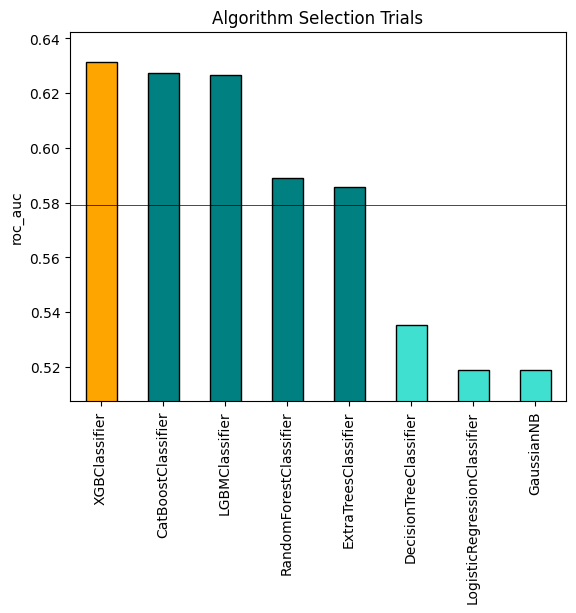

In [32]:
plot_algorithm_selection(estimator_automl)

##### Sampling Adaptativo

Processo de seleção de amostragem do AutoMLx.
- `Y`: Métrica
- `X`: Tamanho da Amostra

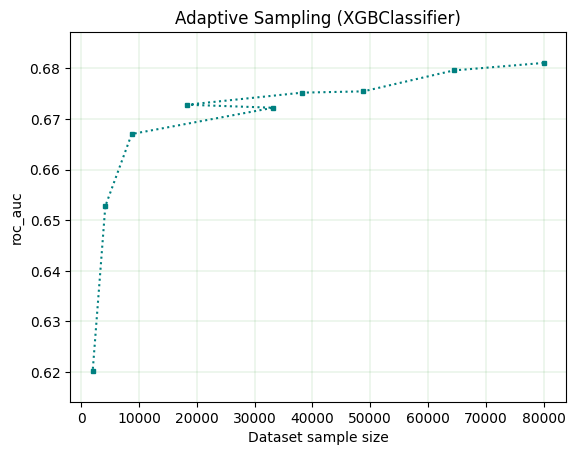

In [33]:
plot_adaptive_sampling(estimator_automl)

##### Seleção de Features

Processo de seleção de features do AutoMLx.
- `Y`: Métrica
- `X`: Número de features

Features selected: ['Aeródromo Destino', 'Aeródromo Origem', 'Data Hora Voo', 'Data Hora Voo__day', 'Data Hora Voo__hour', 'Data Hora Voo__midnight', 'Data Hora Voo__minute', 'Data Hora Voo__month', 'Data Hora Voo__weekday', 'Data Hora Voo__year', 'Distância (m)', 'Empresa Aérea']
Features dropped: []


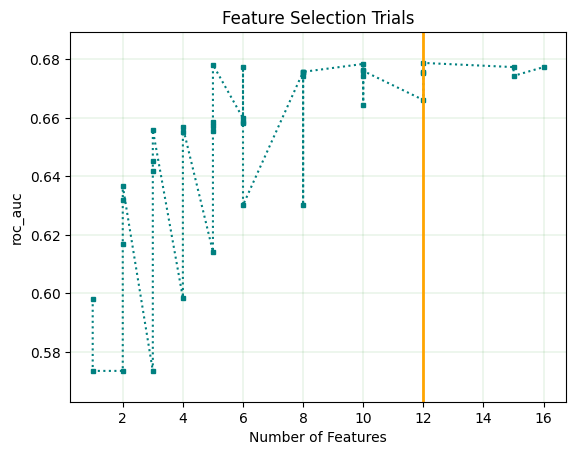

In [34]:
plot_feature_selection(estimator_automl, df.drop(columns=['Atrasado']))

##### Ajuste de Hiperparâmetros

Processo de seleção de hiperparâmetros do AutoMLx.
- `Y`: Métrica
- `X`: Iteração *n*

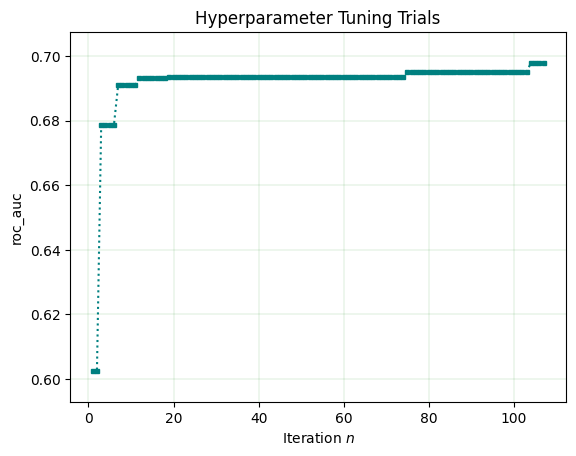

In [35]:
plot_model_tuning(estimator_automl)

### Exportação do Modelo

Aqui exportamos o melhor modelo em formato `.pkl` para uso em inferência.

In [ ]:
model_metadata = get_model_metadata(best_estimator)
print(model_metadata)

{'model': 'LGBMClassifier', 'model_type': 'AutoClassifier', 'specifications': {'num_leaves': 189, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'min_child_weight': 0.001, 'max_depth': -1, 'reg_alpha': 0.13860590871139572, 'reg_lambda': 1, 'n_estimators': 100, 'class_weight': 'balanced'}, 'features': ['Aeródromo Destino', 'Aeródromo Origem', 'Data Hora Voo', 'Data Hora Voo__day', 'Data Hora Voo__evening', 'Data Hora Voo__hour', 'Data Hora Voo__microsecond', 'Data Hora Voo__midnight', 'Data Hora Voo__minute', 'Data Hora Voo__month', 'Data Hora Voo__morning', 'Data Hora Voo__night', 'Data Hora Voo__weekday', 'Data Hora Voo__year', 'Distância (m)', 'Empresa Aérea'], 'features_raw': ['Empresa Aérea', 'Data Hora Voo', 'Aeródromo Origem', 'Aeródromo Destino', 'Distância (m)'], 'training_time': None, 'score_metric': None}


In [37]:
model_metadata = get_model_metadata(best_estimator)
model_filename = export_model(best_estimator, filename=f'flight_delay_{model_metadata["model"]}', timestamp=True)

📁 Arquivo salvo com sucesso:
   → ./models/flight_delay_LGBMClassifier_20260113_194452.pkl



In [38]:
document_model(best_estimator, model_name=model_metadata['model'], model_metadata=model_metadata, model_features=model_metadata['features_raw'], x=X_test, y=y_test, output_format='.md', timestamp=True)

📁 Arquivo salvo com sucesso:
   → ./models/model_documentation_LGBMClassifier_20260113_194504.md


#### Testando o modelo exportado

In [ ]:
test_model(model_filename, X_test)


📊 Testing model: flight_delay_LGBMClassifier_20260113_194452

Test data columns:
Index(['Empresa Aérea', 'Aeródromo Origem', 'Aeródromo Destino',
       'Distância (m)', 'Data Hora Voo'],
      dtype='object')

Predictions on first 10 samples:

   Prediction  Probability_Class_0  Probability_Class_1
0           1             0.374271             0.625729
1           0             0.868186             0.131814
2           1             0.353673             0.646327
3           0             0.590307             0.409693
4           0             0.769311             0.230689
5           0             0.610921             0.389079
6           0             0.592994             0.407006
7           0             0.573483             0.426517
8           0             0.506400             0.493600
9           1             0.495636             0.504364
